## NLP stuff with Spotify User Reviews

Here we load, preprocess and explore Spotify user reviews to learn NLP preprocessing methods and gain first insights into the dataset.

In [339]:
## Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [340]:
## Import general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [341]:
## Read data and copy
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()

In [342]:
## Check Data
data_in.head(10)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN


In [343]:
## Sample some reviews
data_in["Review"].sample(10)

19216    Great app 👌 but if they could put some more op...
56745    Prefer a platform that doesn't traffic in misi...
39601    Excellent. The only thing missing is program n...
42066    I like the app because I can play background m...
32210    I use it almost every day on my other computer...
20663    This is a first class app for music new old re...
42664    I mean it's not the best but I give it 5 stars...
58820    Newest update isn't showing or giving access t...
27741    Says I am offline but I am not. It doesn't wor...
35839    Having issues with the app and no one to talk ...
Name: Review, dtype: object

In [344]:
## Data info
data_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [345]:
## Remove duplicates
## Since we are changing the raw input data, let's change the name to data
print("Before dropping duplicates: ", len(data_in))
data = data_in.drop_duplicates(subset="Review")
print("After dropping duplicates: ", len(data))


Before dropping duplicates:  61594
After dropping duplicates:  61356


In [346]:
## Drop unused cols
data.drop(["Time_submitted", "Total_thumbsup", "Reply"], axis=1, inplace=True)
data.head(5)

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [347]:
## Ad col for reviews length of review in words
data["Length"] = data["Review"].str.split(" ").str.len()
data.head()

,Review,Rating,Length
0,"Great music service, the audio is high quality...",5,21
1,Please ignore previous negative rating. This a...,5,15
2,"This pop-up ""Get the best Spotify experience o...",4,19
3,Really buggy and terrible to use as of recently,1,9
4,Dear Spotify why do I get songs that I didn't ...,1,21


In [348]:
## Check shortest reviews
data.sort_values("Length").head(10)

,Review,Rating,Length
24628,Easy-to-use software,5,2
30670,"Powerful,Spirit-touching songs",5,2
27164,Best music service,5,3
4562,Always interrupts ads,1,3
4569,To many advertisement!!!,1,3
9923,Too much ads.,1,3
4572,Love no ads!,5,3
33635,Brilliant music app,5,3
9938,Full of adds,1,3
13112,Great and dynamic,5,3


In [349]:
## Check longest reviews
data.sort_values("Length").tail(10)

,Review,Rating,Length
61568,I have been using Spotify premium. Biggest dis...,3,150
24495,"SPOTIFY IS TERRIBLE! Before podcasts, Spotify ...",1,157
23836,"Works fine for my phone, however for the past ...",2,159
27916,Edit - came back to remove a star. Jesus cance...,2,165
19664,Spotify is a great way to listen to music alth...,4,175
40973,Although I like Spotify and I use it a lot (an...,3,185
26055,I am giving the 3 month free trial a go and so...,4,219
46004,"I am using Spotify soon for a year, before I u...",4,222
20489,"Attention Android Users: unfortunately, there ...",1,279
40566,"I very rarely leave reviews and if I do, they'...",1,699


<Figure size 1200x600 with 0 Axes>

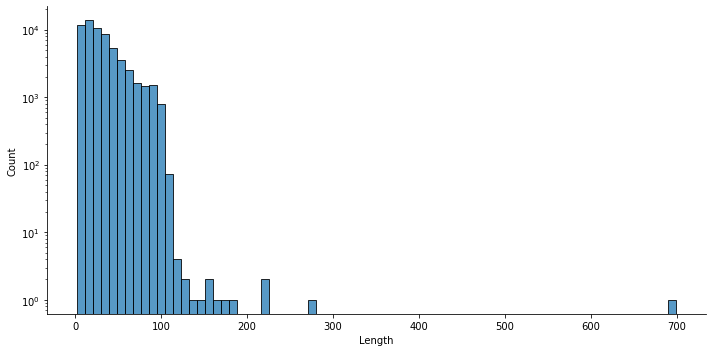

In [350]:
## Plot Review Length as hist
plt.figure(figsize=(4,2), dpi=300)
ax = sns.displot(data["Length"], kind="hist", fill=True, aspect=2, bins=75, log=True);

In [351]:
data["Length"].describe()

count    61356.000000
mean        30.991786
std         22.724590
min          2.000000
25%         14.000000
50%         25.000000
75%         42.000000
max        699.000000
Name: Length, dtype: float64

As we can see, most reviews are no longer than around 120 words; as a next step, we could remove all reviews with more than 150 words.

In [352]:
## Drop long reviews
data = data[data.Length < 150]
print("Number of reviews after trimming: ", len(data))

Number of reviews after trimming:  61346


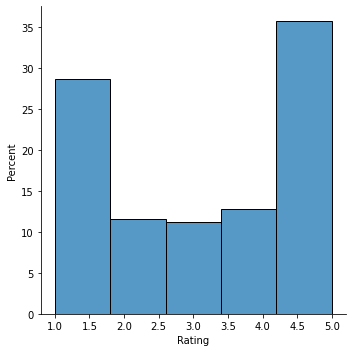

In [353]:
## Visualize distribution of ratings
ax = sns.displot(data=data, x='Rating', stat='percent', bins=5);

In [354]:
## Code sentiment from rating (1 or 2 == bad, 3 == neutral, 4 or 5 == good)
def get_sentiment(rating):
    if rating == 1 or rating == 2:
        return "negative"
    if rating == 3:
        return "neutral"
    if rating == 4 or rating == 5:
        return "positive"

In [355]:
data["Sentiment"] = data["Rating"].apply(get_sentiment)
data.head(10)

,Review,Rating,Length,Sentiment
0,"Great music service, the audio is high quality...",5,21,positive
1,Please ignore previous negative rating. This a...,5,15,positive
2,"This pop-up ""Get the best Spotify experience o...",4,19,positive
3,Really buggy and terrible to use as of recently,1,9,negative
4,Dear Spotify why do I get songs that I didn't ...,1,21,negative
5,The player controls sometimes disappear for no...,3,19,neutral
6,I love the selection and the lyrics are provid...,5,15,positive
7,Still extremely slow when changing storage to ...,3,62,neutral
8,It's a great app and the best mp3 music app I ...,5,43,positive
9,"I'm deleting this app, for the following reaso...",1,80,negative


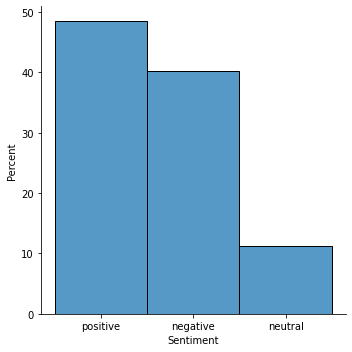

In [356]:
## Plot sentiment distribution (e.g. sns.histplot)
ax = sns.displot(data=data, x='Sentiment', stat='percent');

In [357]:
## Look for relationship between length and sentiment
data[["Length","Sentiment"]].groupby("Sentiment").describe()

Length                                                    
             count       mean        std  min   25%   50%   75%    max
Sentiment                                                             
negative   24713.0  37.777202  23.415594  3.0  20.0  32.0  50.0  137.0
neutral     6874.0  36.963777  23.270817  3.0  19.0  32.0  49.0  111.0
positive   29759.0  23.906885  19.092666  2.0  10.0  18.0  31.0  113.0

### Preprocessing

In [358]:
## Import special libraries
import emojis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize as tokenizer

In [359]:
## Get NLTK english stopwords
our_stopwords = set(stopwords.words('english'))

In [360]:
## Run this to download all NLTK content
## WARNING: This takes a long time.
#nltk.download()

## Text Preprocessing

1. Lowercase
2. Remove Punct
3. Tokenize with standard tokenizer
4. Remove Stopwords

In [361]:
## 1. Lowercase all words
data["Review"] = data["Review"].str.lower()
data.head()

,Review,Rating,Length,Sentiment
0,"great music service, the audio is high quality...",5,21,positive
1,please ignore previous negative rating. this a...,5,15,positive
2,"this pop-up ""get the best spotify experience o...",4,19,positive
3,really buggy and terrible to use as of recently,1,9,negative
4,dear spotify why do i get songs that i didn't ...,1,21,negative


In [362]:
data["Review"].sample(20)

20163                         constant crashes fix the app
36181    all screwed up now. stops showing what music i...
61064    ok software but the free version is almost unu...
12490     change the outlook of spotify on android version
21255    best app for music ever..theyve told you the l...
37512    what is going on with this app? it's so glitch...
38479    i love adam corolla show, and i find it on spo...
7525                              app not running on wifi.
54624    spotify is participating in censorship. uninst...
31084              it is great but i cannot get every song
36756    the app lately is horrible. so many small bugs...
57231    on premium and it constantly freezes and is sl...
7226     a glitch keeps removing the play bar at the bo...
58137    thank you spotify for holding strong and not c...
27774                   excellent options and good music 🎶
8448           very slow, keeps crashing, removed car mode
588      this app is really good but sometimes there ar.

In [363]:
## 2./3. Tokenize Remove Punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [364]:
tokens = data["Review"].apply(tokenizer.tokenize)

In [365]:
tokens.sample(20)

59519    [very, good, quality, and, selection, of, musi...
19310              [this, music, app, has, too, much, ads]
3019     [let, the, app, keep, the, phone, unlocked, wh...
49382    [i, had, youtube, music, forever, then, they, ...
43725    [excellent, player, would, you, mind, thinking...
12872        [i, tried, many, times, but, can, t, get, it]
8717     [there, is, a, new, feature, where, it, doesn,...
16923    [i, love, listening, to, my, fav, music, on, s...
7038     [i, love, this, app, bc, it, has, any, types, ...
46182    [i, was, listening, to, epic, gamer, music, wh...
26946    [still, no, changelog, poor, why, can, t, you,...
60608    [best, music, app, out, there, it, s, like, yo...
29372    [for, my, opinion, spotify, is, the, best, sou...
17064    [it, s, a, good, app, overall, but, i, can, t,...
5336     [can, not, download, some, of, the, songs, tha...
9990     [i, ve, been, using, spotify, for, a, while, n...
55582    [still, can, t, believe, i, pay, for, this, by.

In [366]:
## Join tokens to our dataframe
data["Tokens"] = tokens

In [367]:
data.head()

,Review,Rating,Length,Sentiment,Tokens
0,"great music service, the audio is high quality...",5,21,positive,"[great, music, service, the, audio, is, high, ..."
1,please ignore previous negative rating. this a...,5,15,positive,"[please, ignore, previous, negative, rating, t..."
2,"this pop-up ""get the best spotify experience o...",4,19,positive,"[this, pop, up, get, the, best, spotify, exper..."
3,really buggy and terrible to use as of recently,1,9,negative,"[really, buggy, and, terrible, to, use, as, of..."
4,dear spotify why do i get songs that i didn't ...,1,21,negative,"[dear, spotify, why, do, i, get, songs, that, ..."


In [368]:
## 4. Remove Stopwords
## Here we loop through each list of words and remove stopwords
data['Tokens_no_stopwords'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.head()

,Review,Rating,Length,Sentiment,Tokens,Tokens_no_stopwords
0,"great music service, the audio is high quality...",5,21,positive,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating. this a...,5,15,positive,"[please, ignore, previous, negative, rating, t...","[please, ignore, previous, negative, rating, a..."
2,"this pop-up ""get the best spotify experience o...",4,19,positive,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, spotify, experience, android,..."
3,really buggy and terrible to use as of recently,1,9,negative,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn't ...,1,21,negative,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, spotify, get, songs, put, playlist, shu..."


## TEXT TRANSFORMATIONS
5. Bag of Word Model/Count Vectorize
6. Term-Frequency Inverse-Document-Frequency (TF-IDF)/ TFIDF Vectorizer
7. Delete highly frequent tokens (tokens that are in 90% of docs)
8. Delete very low frequent tokens (tokens that are in less than 5% of docs)

Until now, the text was still in text form; all we did was cleaning words and characters that won't give us a lot of signal. The next step, however, is to _transform_ the text into numeric representations, aka something a computer can understand. This involves fitting a transformer to data. In order to prevent __data spillage__, it is important to split our data into a training, development, and test set. Any transformer should only be fit to the training data set.

In [369]:
## Split data into train, dev, and test set
from sklearn.model_selection import train_test_split

In [370]:
X = data["Tokens_no_stopwords"]
y = data["Sentiment"]
print("Shape of X and y: ", X.shape, y.shape)

Shape of X and y:  (61346,) (61346,)


In [371]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36807,) (24539,) (36807,) (24539,)


In [372]:
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state=42)
print(X_dev.shape, X_test.shape, y_dev.shape, y_test.shape)

(12269,) (12270,) (12269,) (12270,)


In [379]:
print(y_train.unique(), y_test.unique(), y_dev.unique())

['positive' 'negative' 'neutral'] ['neutral' 'negative' 'positive'] ['neutral' 'negative' 'positive']


In [380]:
## Encode labels in sklearn style
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)

In [381]:
## TRANSFORMATIONS
## 5. Counts
from sklearn.feature_extraction.text import CountVectorizer

In [382]:
## hacky solution, meh
def dummy(doc):
    return doc
count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
## Only fit on training set
count_vectorizer.fit(X_train)
X_train_counts = count_vectorizer.transform(X_train)
X_dev_counts = count_vectorizer.transform(X_dev)


In [383]:
## We can get the vocabulary (= all our tokens) from the vectorizer as a dict
vocabulary = count_vectorizer.vocabulary_
list(vocabulary.keys())[:10] # Show ten

['loving',
 'app',
 'lots',
 'music',
 'choose',
 'podcasts',
 'turn',
 'bluetooth',
 'notification',
 'every']

In [384]:
## Let's have a look at tokens and their ID, sorted alphabetically
pd.DataFrame(vocabulary.items()).rename(columns={0: "token", 1: "ID"}).sort_values("ID", ascending=True).head(10)

,token,ID
331,0,0
3446,00,1
3301,000,2
4961,000000001,3
14200,001,4
14752,003,5
9606,00348,6
14753,005,7
106,00s,8
4007,01,9


In [385]:
## Same for the tail
pd.DataFrame(vocabulary.items()).rename(columns={0: "token", 1: "ID"}).sort_values("ID", ascending=True).tail(10)

,token,ID
8714,𝚑𝚊𝚟𝚎,18297
8713,𝚒,18298
5355,𝚒𝚜,18299
8716,𝚕𝚘𝚟𝚎𝚍,18300
5357,𝚖𝚘𝚜𝚝,18301
5359,𝚖𝚞𝚜𝚒𝚌,18302
5356,𝚝𝚑𝚎,18303
5353,𝚝𝚑𝚒𝚗𝚔,18304
5354,𝚝𝚑𝚒𝚜,18305
4482,𝟐𝐱,18306


We see that we have a lot of digits and strange font words that we might want to take care of later. Also, our dictionary contains __18 306 tokens__.

In [386]:
## TRANSFORMATIONS
## 5. TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [387]:
## hacky solution
def dummy(doc):
    return doc
tfidf_vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy)
## Only fit on training set
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)

## Classification of sentiment

In [404]:
## Import some classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier # never used that one before

### Use Bag of Words/Count vectorized features for classification

In [409]:
## Initlilize classifiers with default hyperparams
log1 = LogisticRegression()
rf1 = RandomForestClassifier()
svc1 = SVC()
nb1 = MultinomialNB()
gbm1 = LGBMClassifier(objective='multiclass')

X_train_counts = X_train_counts.astype('float32')
X_dev_counts = X_dev_counts.astype('float32')   
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


classifiers = [log1, rf1, svc1, nb1, gbm1]
results_counts = []

for classifier in classifiers:
    print(f"Fitting {classifier}...")
    classifier.fit(X_train_counts, y_train)
    print(f"{classifier} accuracy on Count Vector: {classifier.score(X_dev_counts, y_dev)}")


Fitting LogisticRegression()...
LogisticRegression() accuracy on Count Vector: 0.7697448854837395
Fitting RandomForestClassifier()...
RandomForestClassifier() accuracy on Count Vector: 0.7714565164235064
Fitting SVC()...
SVC() accuracy on Count Vector: 0.7818893145325617
Fitting MultinomialNB()...
MultinomialNB() accuracy on Count Vector: 0.7719455538348684
Fitting LGBMClassifier(objective='multiclass')...
LGBMClassifier(objective='multiclass') accuracy on Count Vector: 0.779281115005298


### TFIDF Vectorized features for classification

In [410]:
## Initlilize classifiers with default hyperparams
log2 = LogisticRegression()
rf2 = RandomForestClassifier()
svc2 = SVC()
nb2 = MultinomialNB()
gbm2 = LGBMClassifier(objective='multiclass')

X_train_tfidf = X_train_tfidf.astype('float32')
X_dev_tfidf = X_dev_tfidf.astype('float32')   
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


classifiers = [log2, rf2, svc2, nb2, gbm2]
results_counts = []

for classifier in classifiers:
    print(f"Fitting {classifier}...")
    classifier.fit(X_train_tfidf, y_train)
    print(f"{classifier} accuracy on TF-IDF Vector: {classifier.score(X_dev_tfidf, y_dev)}")


Fitting LogisticRegression()...
LogisticRegression() accuracy on TF-IDF Vector: 0.7858016138234575
Fitting RandomForestClassifier()...
RandomForestClassifier() accuracy on TF-IDF Vector: 0.7675442171326107
Fitting SVC()...
SVC() accuracy on TF-IDF Vector: 0.7891433694677643
Fitting MultinomialNB()...
MultinomialNB() accuracy on TF-IDF Vector: 0.7747982720678132
Fitting LGBMClassifier(objective='multiclass')...
LGBMClassifier(objective='multiclass') accuracy on TF-IDF Vector: 0.7760208655962181
